In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print(train.shape)
train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We cannot just drop na, because all rows contain null values

In [4]:
train.dropna().shape

(0, 81)

But not that many columns contain nulls, so we can try to drop columns

In [5]:
train.isna().any()[:10]

Id             False
MSSubClass     False
MSZoning       False
LotFrontage     True
LotArea        False
Street         False
Alley           True
LotShape       False
LandContour    False
Utilities      False
dtype: bool

In [6]:
train.dropna(axis=1).shape

(1460, 62)

In [7]:
train = train.dropna(axis=1)

And we also don't need id and target

In [8]:
X = train.iloc[:,1:-1]
y = train.iloc[:,-1]

In [9]:
X.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,84,0,0,0,0,0,12,2008,WD,Normal


In [10]:
y.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

We also need to encode categorical features - objects

In [11]:
X.dtypes[:5]

MSSubClass     int64
MSZoning      object
LotArea        int64
Street        object
LotShape      object
dtype: object

In [12]:
categorical_cols = X.columns[X.dtypes==object].tolist()
len(categorical_cols)

27

In [13]:
cat_df = X.select_dtypes(include=['object']).copy()
X.drop(X.select_dtypes(['object']), inplace=True, axis=1)

cat_df = pd.get_dummies(cat_df, columns=categorical_cols, prefix=categorical_cols)
cat_df.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0


Combine categorical and numeric features back together

In [14]:
X_categorized = pd.concat([X, cat_df], sort=False, axis=1)

X_categorized.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,7,5,2003,2003,706,0,150,856,...,0,0,0,1,0,0,0,0,1,0
1,20,9600,6,8,1976,1976,978,0,284,1262,...,0,0,0,1,0,0,0,0,1,0
2,60,11250,7,5,2001,2002,486,0,434,920,...,0,0,0,1,0,0,0,0,1,0
3,70,9550,7,5,1915,1970,216,0,540,756,...,0,0,0,1,1,0,0,0,0,0
4,60,14260,8,5,2000,2000,655,0,490,1145,...,0,0,0,1,0,0,0,0,1,0


In [15]:
train_X, test_X, train_y, test_y = train_test_split(X_categorized, y, test_size=0.3)

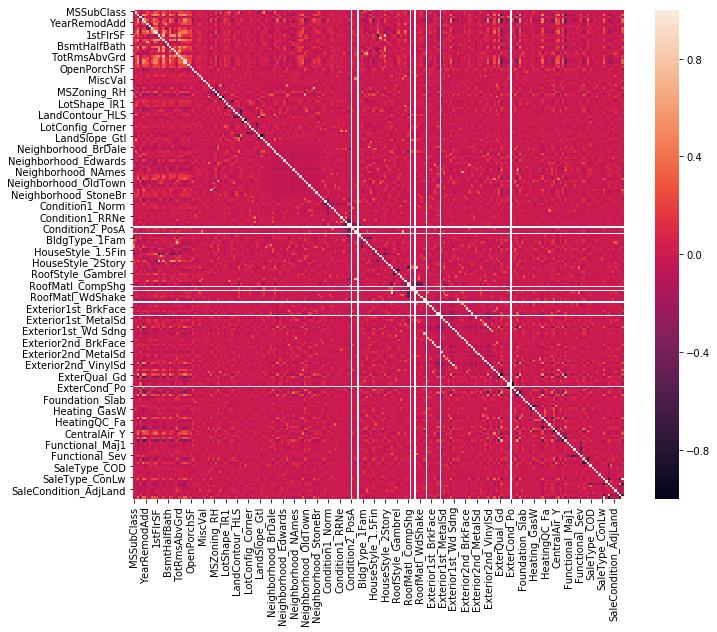

In [16]:
f, ax = plt.subplots(figsize=(11, 9))
corr = train_X.corr()
sns.heatmap(corr)

I've decided to use Lasso because some features correlate

In [17]:
lasso_model = Lasso(normalize=True, max_iter=3000)
lasso_model.fit(train_X, train_y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=3000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [18]:
y_pred = lasso_model.predict(test_X)
mean_absolute_error(test_y, y_pred)

17399.593669331705

In [19]:
for i in range(10):
    print('predicted:', y_pred[i], 'actual:', test_y.values.tolist()[i])

predicted: 121188.87185540865 actual: 144000
predicted: 130945.61328422022 actual: 113000
predicted: 309936.49227559846 actual: 348000
predicted: 382731.1360001087 actual: 451950
predicted: 150763.67839975748 actual: 135000
predicted: 109652.42849775474 actual: 100000
predicted: 151922.127498982 actual: 133900
predicted: 178534.5823050039 actual: 140000
predicted: 168592.79413935123 actual: 127000
predicted: 153787.98121852102 actual: 151000


Also I've seen suggestions to use XG Boost.
So I'll try that and pick model with least mae

In [20]:
boost_model = XGBRegressor()
boost_model.fit(train_X, train_y)
boost_pred = boost_model.predict(test_X)
print(mean_absolute_error(test_y, boost_pred))

15876.968027611301


So mae in boost is smaller even without any params

In [21]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [300, 700, 1000, 1500, 2000],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1]
}

clf = GridSearchCV(XGBRegressor(), params, cv=5, verbose=True)
clf.fit(train_X, train_y)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed: 37.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 4, 5], 'n_estimators': [300, 700, 1000, 1500, 2000], 'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [22]:
clf.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 700}

I've got best params {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
(probably should've used random state)

In [23]:
boost_with_params = XGBRegressor(n_estimators=700, max_depth=3, learning_rate=0.1)
boost_with_params.fit(train_X, train_y)
boost_with_params_pred = boost_with_params.predict(test_X)
print(mean_absolute_error(test_y, boost_with_params_pred))

15457.575173016552


In [24]:
for i in range(10):
    print('predicted:', boost_with_params_pred[i], 'actual:', test_y.values.tolist()[i])

predicted: 139685.02 actual: 144000
predicted: 137778.4 actual: 113000
predicted: 315003.44 actual: 348000
predicted: 465767.7 actual: 451950
predicted: 157935.52 actual: 135000
predicted: 87756.24 actual: 100000
predicted: 167784.4 actual: 133900
predicted: 182650.3 actual: 140000
predicted: 145740.5 actual: 127000
predicted: 149984.12 actual: 151000


I'm content with results

In [25]:
boost_with_params = XGBRegressor(n_estimators=700, max_depth=3, learning_rate=0.1)
boost_with_params.fit(X_categorized, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=700,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Same preprocessing as before

In [26]:
test_copy = test.copy().iloc[:,1:]

categorical_cols = test_copy.columns[test_copy.dtypes==object].tolist()
cat_df = test_copy.select_dtypes(include=['object']).copy()
test_copy.drop(test_copy.select_dtypes(['object']), inplace=True, axis=1)

cat_df = pd.get_dummies(cat_df, columns=categorical_cols, prefix=categorical_cols)

test_copy_cat = pd.concat([test_copy, cat_df], sort=False, axis=1)

Selecting only columns that were in training data

In [27]:
test_copy_cat = test_copy_cat[test_copy_cat.columns & X_categorized.columns]
difference = list(set(X_categorized) - set(test_copy_cat))
dict = {}
for column_name in difference:
    dict[X_categorized.columns.get_loc(column_name)] = column_name

for idx in sorted(dict.keys()):
    test_copy_cat.insert(idx, dict[idx], 0)

In [28]:
list(test_copy_cat.columns) == list(X_categorized.columns)

True

In [29]:
test_copy_cat.fillna(0, inplace=True)
test_copy_cat.isnull().values.any()

False

In [30]:
prediction = boost_with_params.predict(test_copy_cat)
prediction[:5]

array([122565.22, 172130.88, 180979.84, 197805.75, 180792.36],
      dtype=float32)

In [31]:
ids = test.copy().iloc[:,0]
ids[-5:]

1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, dtype: int64

In [32]:
len(prediction), len(ids)

(1459, 1459)

In [33]:
f = open('result.csv','w')
f.write('Id,SalePrice\n')
for i, pred in zip(ids, prediction):
    f.write(str(i) + ',' + str(pred))
    f.write('\n')